In [108]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn
from torch.utils.data import Dataset, DataLoader, BatchSampler, RandomSampler
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
male = np.load("male_spect.npy")

In [3]:
male.shape
min([mal.shape[0] for mal in male])

282

In [4]:
male[0].shape

(348, 129)

In [15]:
class TrainDataset(Dataset):
    def __init__(self, train):
        self.train = train
        lens = [a.shape[0] for a in train]
        self.max_len = np.max(lens)
    
    def __len__(self):
        return self.train.shape[0]
    
    def __getitem__(self, idx):
        diff = self.max_len - self.train[idx].shape[0]
        train = np.pad(self.train[idx], [(0, diff),(0,0)], "constant", constant_values=0)
        train = train[:1000,:]
        return train

In [16]:
train_dataset = TrainDataset(male)

In [17]:
train_dataset[5].shape

(1000, 129)

In [18]:
batch_size = 20
train_loader = DataLoader(train_dataset,
                        batch_sampler=BatchSampler(RandomSampler(train_dataset), batch_size, False))

In [19]:
iter(train_loader).next().shape

torch.Size([20, 1000, 129])

In [20]:
class Generator(nn.Module):
     def __init__(self, hidden_size=129):
        super(Generator, self).__init__()
        self.rnn = nn.LSTM(200, hidden_size, num_layers=3, batch_first=True)
     
     def forward(self, z):
        x,_ = self.rnn(z)
        return x
            

In [28]:
class Discriminator(nn.Module):
    def __init__(self, hidden_size=50):
        super(Discriminator, self).__init__()
        self.rnn = nn.LSTM(129, hidden_size, num_layers=3, batch_first=True)
        self.linear = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        x,_ = self.rnn(x)
        x = self.linear(x)
        return x

In [92]:
def train_epoch(gen, disc, optimizer1, optimizer2, train_loader, epoch):
    batch_size = 20
    criterion = nn.CrossEntropyLoss() 
    criterion = criterion.to(DEVICE)
    false_label = torch.zeros((batch_size * 1000)).long()
    true_label = torch.ones((batch_size * 1000)).long()
    false_label = false_label.to(DEVICE)
    true_label = true_label.to(DEVICE)
    batch_id=0
    losses = []
    gen.train()
    disc.train()
    for inputs in train_loader: # lists, presorted, preloaded on GPU
        batch_id+=1
        #discriminator
        inputs = inputs.to(DEVICE)
        output = disc(inputs)
        output = output.view(-1,2)
    #   print(output.shape)
        d_loss = criterion(output, true_label)
        z = torch.randn((batch_size,1000, 200))
        z = z.to(DEVICE)
    #   print(z.shape)
        output = gen(z)
        output = disc(output)
        output = output.view(-1,2)
    #   print(output.shape)
        d_loss = d_loss + criterion(output, false_label)
        optimizer2.zero_grad()
        d_loss.backward()
        optimizer2.step()
        
        # generator
        z = torch.randn((batch_size,1000, 200))
        z = z.to(DEVICE)
    #   print(z.shape)
        output = gen(z)
        output = disc(output)
        output = output.view(-1,2)
    #   print(output.shape)
        g_loss = criterion(output, true_label)
        optimizer1.zero_grad()
        g_loss.backward()
        optimizer1.step()
        
        # generator
        z = torch.randn((batch_size,1000, 200))
        z = z.to(DEVICE)
    #   print(z.shape)
        output = gen(z)
        output = disc(output)
        output = output.view(-1,2)
    #   print(output.shape)
        g_loss = criterion(output, true_label)
        optimizer1.zero_grad()
        g_loss.backward()
        optimizer1.step()
        print("discriminator loss", d_loss.item())
        print("generator loss", g_loss.item())
      

In [93]:
gen = Generator()
gen = gen.to(DEVICE)
disc = Discriminator()
disc = disc.to(DEVICE)
optimizer1 = torch.optim.Adam(gen.parameters(),lr=0.001)
optimizer2 = torch.optim.Adam(disc.parameters(),lr=0.001)

/jet/var/python/lib/python3.6/site-packages/torch/backends/cudnn/__init__.py:89: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


In [94]:
for i in range(10):
    train_epoch(gen, disc, optimizer1, optimizer2, train_loader, i+1)

/jet/var/python/lib/python3.6/site-packages/torch/backends/cudnn/__init__.py:89: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


discriminator loss 1.3948229551315308
generator loss 0.7531701922416687
discriminator loss 1.3893513679504395
generator loss 0.7437283396720886
discriminator loss 1.384484052658081
generator loss 0.7339949011802673
discriminator loss 1.381791114807129
generator loss 0.7223305106163025
discriminator loss 1.3852601051330566
generator loss 0.7061796188354492
discriminator loss 1.3915152549743652
generator loss 0.6863996982574463
discriminator loss 1.4058239459991455
generator loss 0.6752817630767822
discriminator loss 1.4070806503295898
generator loss 0.6739466190338135
discriminator loss 1.4096896648406982
generator loss 0.6775885224342346
discriminator loss 1.3909542560577393
generator loss 0.6876012086868286
discriminator loss 1.3872675895690918
generator loss 0.700061559677124
discriminator loss 1.3631446361541748
generator loss 0.7132459282875061
discriminator loss 1.3513381481170654
generator loss 0.7266731262207031
discriminator loss 1.3344664573669434
generator loss 0.739192843437

discriminator loss 1.0847015380859375
generator loss 0.9003280997276306
discriminator loss 0.9828113317489624
generator loss 0.9084916710853577
discriminator loss 1.0343375205993652
generator loss 0.9180574417114258
discriminator loss 1.0041536092758179
generator loss 0.9198489189147949
discriminator loss 0.9268317222595215
generator loss 0.9233832955360413
discriminator loss 1.026549220085144
generator loss 0.923697829246521
discriminator loss 0.9899085164070129
generator loss 0.9204850792884827
discriminator loss 0.9916849136352539
generator loss 0.9142537117004395
discriminator loss 0.9595968723297119
generator loss 0.911061704158783
discriminator loss 1.0475102663040161
generator loss 0.9078637957572937
discriminator loss 1.0349607467651367
generator loss 0.8998708724975586
discriminator loss 0.9727544784545898
generator loss 0.8750684857368469
discriminator loss 1.088161826133728
generator loss 0.8400493264198303
discriminator loss 1.140860676765442
generator loss 0.76086908578872

discriminator loss 0.11222709715366364
generator loss 2.5042102336883545
discriminator loss 0.09961740672588348
generator loss 2.6026477813720703
discriminator loss 0.10527590662240982
generator loss 2.7009613513946533
discriminator loss 0.08518364280462265
generator loss 2.802434206008911
discriminator loss 0.07567059993743896
generator loss 2.9051108360290527
discriminator loss 0.07239153236150742
generator loss 3.005774974822998
discriminator loss 0.08083082735538483
generator loss 3.100555181503296
discriminator loss 0.06342265009880066
generator loss 3.189732551574707
discriminator loss 0.06050081178545952
generator loss 3.2795968055725098
discriminator loss 0.0509614422917366
generator loss 3.368835926055908
discriminator loss 0.05913594737648964
generator loss 3.454396963119507
discriminator loss 0.059674326330423355
generator loss 3.5270297527313232
discriminator loss 0.043961867690086365
generator loss 3.593125343322754
discriminator loss 0.049833815544843674
generator loss 3.

discriminator loss 0.01766049675643444
generator loss 5.808305740356445
discriminator loss 0.009188818745315075
generator loss 5.816295623779297
discriminator loss 0.010281957685947418
generator loss 5.824254512786865
discriminator loss 0.008184477686882019
generator loss 5.832139492034912
discriminator loss 0.01751561462879181
generator loss 5.839189529418945
discriminator loss 0.008996364660561085
generator loss 5.846004486083984
discriminator loss 0.0133994584903121
generator loss 5.852566242218018
discriminator loss 0.008588318713009357
generator loss 5.8599324226379395
discriminator loss 0.008294012397527695
generator loss 5.86779260635376
discriminator loss 0.008101354353129864
generator loss 5.8756794929504395
discriminator loss 0.023070532828569412
generator loss 5.882528305053711
discriminator loss 0.013081694021821022
generator loss 5.889167785644531
discriminator loss 0.007920976728200912
generator loss 5.895895481109619
discriminator loss 0.03602734953165054
generator loss 

discriminator loss 0.009942352771759033
generator loss 6.281829357147217
discriminator loss 0.013185139745473862
generator loss 6.276418685913086
discriminator loss 0.006088285241276026
generator loss 6.272537708282471
discriminator loss 0.006386167369782925
generator loss 6.26996374130249
discriminator loss 0.01570531539618969
generator loss 6.267168998718262
discriminator loss 0.015899715945124626
generator loss 6.264749526977539
discriminator loss 0.006688945926725864
generator loss 6.263193130493164
discriminator loss 0.005873586051166058
generator loss 6.261564254760742
discriminator loss 0.006877797655761242
generator loss 6.251350402832031
discriminator loss 0.011366620659828186
generator loss 6.178253650665283
discriminator loss 0.376299113035202
generator loss 6.1615447998046875
discriminator loss 0.011614765040576458
generator loss 6.282689571380615
discriminator loss 0.017278049141168594
generator loss 6.293318748474121
discriminator loss 0.009641466662287712
generator loss 

discriminator loss 0.2716350555419922
generator loss 4.451755523681641
discriminator loss 0.28151780366897583
generator loss 4.498044490814209
discriminator loss 0.24616265296936035
generator loss 4.544201374053955
discriminator loss 0.22720825672149658
generator loss 4.589153289794922
discriminator loss 0.21724671125411987
generator loss 4.637607574462891
discriminator loss 0.19594374299049377
generator loss 4.679917335510254
discriminator loss 0.1867697685956955
generator loss 4.722402095794678
discriminator loss 0.1795613169670105
generator loss 4.764372825622559
discriminator loss 0.18810617923736572
generator loss 4.807122230529785
discriminator loss 0.1699499785900116
generator loss 4.848878383636475
discriminator loss 0.16668131947517395
generator loss 4.887827396392822
discriminator loss 0.13894295692443848
generator loss 4.92429256439209
discriminator loss 0.15748676657676697
generator loss 4.9578423500061035
discriminator loss 0.14439046382904053
generator loss 4.991373062133

discriminator loss 0.019782215356826782
generator loss 5.967090129852295
discriminator loss 0.020405497401952744
generator loss 5.965447425842285
discriminator loss 0.05245748162269592
generator loss 5.96306848526001
discriminator loss 0.028697598725557327
generator loss 5.9605817794799805
discriminator loss 0.020903753116726875
generator loss 5.957911491394043
discriminator loss 0.026440635323524475
generator loss 5.958372116088867
discriminator loss 0.03387688100337982
generator loss 5.958870887756348
discriminator loss 0.01972248964011669
generator loss 5.960272312164307
discriminator loss 0.018801139667630196
generator loss 5.962238788604736
discriminator loss 0.025176186114549637
generator loss 5.964620113372803
discriminator loss 0.020344944670796394
generator loss 5.967539310455322
discriminator loss 0.022758368402719498
generator loss 5.971036434173584
discriminator loss 0.03236923739314079
generator loss 5.975163459777832
discriminator loss 0.017657198011875153
generator loss 

discriminator loss 0.01979077234864235
generator loss 6.390270233154297
discriminator loss 0.009766407310962677
generator loss 6.39418888092041
discriminator loss 0.02093750238418579
generator loss 6.3978753089904785
discriminator loss 0.011549683287739754
generator loss 6.401721477508545
discriminator loss 0.012432042509317398
generator loss 6.405561923980713
discriminator loss 0.013440900482237339
generator loss 6.409381866455078
discriminator loss 0.010867981240153313
generator loss 6.413344860076904
discriminator loss 0.009898382239043713
generator loss 6.417457580566406
discriminator loss 0.01236794888973236
generator loss 6.421577453613281
discriminator loss 0.009708093479275703
generator loss 6.425776481628418
discriminator loss 0.02403399534523487
generator loss 6.429597854614258
discriminator loss 0.025901198387145996
generator loss 6.432963848114014
discriminator loss 0.01144441682845354
generator loss 6.436410903930664
discriminator loss 0.02035059966146946
generator loss 6.

discriminator loss 0.02860327810049057
generator loss 6.5974273681640625
discriminator loss 0.017464375123381615
generator loss 6.595026016235352
discriminator loss 0.031187091022729874
generator loss 6.592390537261963
discriminator loss 0.012735020369291306
generator loss 6.590301513671875
discriminator loss 0.009461530484259129
generator loss 6.588956832885742
discriminator loss 0.014005406759679317
generator loss 6.587962627410889
discriminator loss 0.018507448956370354
generator loss 6.587267875671387
discriminator loss 0.010242737829685211
generator loss 6.587242126464844
discriminator loss 0.011913031339645386
generator loss 6.587545394897461
discriminator loss 0.021688416600227356
generator loss 6.587819576263428
discriminator loss 0.015973802655935287
generator loss 6.588291168212891
discriminator loss 0.02523137256503105
generator loss 6.588662624359131
discriminator loss 0.024900639429688454
generator loss 6.58854866027832
discriminator loss 0.012874063104391098
generator los

discriminator loss 0.038585178554058075
generator loss 6.250871181488037
discriminator loss 0.06243158504366875
generator loss 6.247631072998047
discriminator loss 0.052115555852651596
generator loss 6.2464280128479
discriminator loss 0.03697589412331581
generator loss 6.247284412384033
discriminator loss 0.040850576013326645
generator loss 6.247105121612549
discriminator loss 0.04656152427196503
generator loss 6.248251438140869
discriminator loss 0.04301953315734863
generator loss 6.248128890991211
discriminator loss 0.06500812619924545
generator loss 6.233416557312012
discriminator loss 0.025865629315376282
generator loss 6.228052616119385
discriminator loss 0.0647018700838089
generator loss 6.223866939544678
discriminator loss 0.026576658710837364
generator loss 6.224430561065674
discriminator loss 0.024974264204502106
generator loss 6.225844383239746
discriminator loss 0.02996002323925495
generator loss 6.226097106933594
discriminator loss 0.032764047384262085
generator loss 6.2244

discriminator loss 0.2460576891899109
generator loss 4.395233631134033
discriminator loss 0.15547049045562744
generator loss 4.333837032318115
discriminator loss 0.03907753527164459
generator loss 4.301209926605225
discriminator loss 0.05646631494164467
generator loss 4.279609203338623
discriminator loss 0.17582622170448303
generator loss 4.254611492156982
discriminator loss 0.04188590496778488
generator loss 4.242149829864502
discriminator loss 0.04417845979332924
generator loss 4.240706920623779
discriminator loss 0.15427266061306
generator loss 4.237214088439941
discriminator loss 0.11181820183992386
generator loss 4.236595630645752
discriminator loss 0.042819175869226456
generator loss 4.245900630950928
discriminator loss 0.04653075709939003
generator loss 4.263295650482178
discriminator loss 0.05139078199863434
generator loss 4.287102699279785
discriminator loss 0.030753139406442642
generator loss 4.318051338195801
discriminator loss 0.052262093871831894
generator loss 4.352517127

discriminator loss 0.07568897306919098
generator loss 4.464229583740234
discriminator loss 0.14473113417625427
generator loss 4.4780120849609375
discriminator loss 0.22508037090301514
generator loss 4.491696357727051
discriminator loss 0.2508685290813446
generator loss 3.8845815658569336
discriminator loss 0.720853865146637
generator loss 3.478854179382324
discriminator loss 0.35757195949554443
generator loss 4.525448799133301
discriminator loss 0.3618369996547699
generator loss 4.122042179107666
discriminator loss 0.4533066153526306
generator loss 4.540596008300781
discriminator loss 0.2854778468608856
generator loss 4.543069839477539
discriminator loss 0.09225156903266907
generator loss 4.547147750854492
discriminator loss 0.08195112645626068
generator loss 4.551638603210449
discriminator loss 0.05992187187075615
generator loss 4.55842924118042
discriminator loss 0.11615912616252899
generator loss 4.563870429992676
discriminator loss 0.07277509570121765
generator loss 4.5702185630798

KeyboardInterrupt: 

In [97]:
z = torch.randn((batch_size,1000, 200))
z = z.to(DEVICE)
output = gen(z)

/jet/var/python/lib/python3.6/site-packages/torch/backends/cudnn/__init__.py:89: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


In [104]:
output = output.detach().cpu().numpy()
output.shape

(20, 1000, 129)

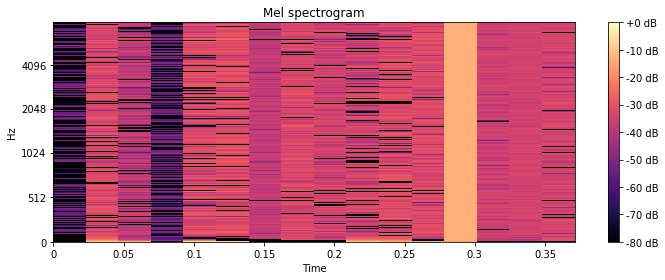

In [135]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(comps, ref=np.max),y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [133]:
# ipd.Audio(output[4].reshape(-1), rate= 22050)
comps, acts = librosa.decompose.decompose(np.abs(output[0]), n_components=16, sort=True)
print(comps.shape)
print(acts.shape)

(1000, 16)
(16, 129)


In [154]:
ipd.display(ipd.Audio(male[0], rate=16000))

In [148]:
librosa.output.write_wav("male.wav", male[0], 22050)
x, sr = librosa.load('male.wav')

TypeError: write_wav() missing 1 required positional argument: 'sr'

In [147]:
# ipd.Audio(x, rate= 22050)

array([], dtype=float32)